In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import torchvision.io as tv_io
from torchvision.models import inception_v3, Inception_V3_Weights
import glob
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [ ]:
weights = Inception_V3_Weights.IMAGENET1K_V1  # Sử dụng trọng số ImageNet
inception_model = inception_v3(weights=weights)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 102MB/s] 


In [ ]:
N_CLASSES = 6  # 6 lớp trái cây
# Thay đổi lớp fully connected cuối cùng của Inception V3
inception_model.fc = nn.Sequential(
    nn.Linear(inception_model.fc.in_features, 500),  # fc.in_features = 2048
    nn.ReLU(),
    nn.Linear(500, N_CLASSES)
)
my_model = inception_model.to(device)

In [ ]:
loss_function = nn.CrossEntropyLoss()  # Dùng cho bài toán đa lớp
optimizer = Adam(my_model.parameters())
my_model = torch.compile(my_model)


In [ ]:
pre_trans = weights.transforms()

In [ ]:
IMG_WIDTH, IMG_HEIGHT = (299, 299)  # Kích thước ảnh Inception V3 yêu cầu
random_trans = transforms.Compose([
    transforms.RandomRotation(10),  # Xoay ngẫu nhiên trong khoảng ±10 độ
    transforms.RandomHorizontalFlip(),  # Lật ngang ngẫu nhiên
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Điều chỉnh màu nhẹ
])

In [ ]:
DATA_LABELS = ["freshapples", "freshbanana", "freshoranges",
               "rottenapples", "rottenbanana", "rottenoranges"]

class MyDataset(Dataset):
    def __init__(self, data_dir):
        self.imgs = []
        self.labels = []

        for l_idx, label in enumerate(DATA_LABELS):
            data_paths = glob.glob(data_dir + label + '/*.png', recursive=True)
            for path in data_paths:
                img = tv_io.read_image(path, tv_io.ImageReadMode.RGB)
                self.imgs.append(pre_trans(img).to(device))
                self.labels.append(torch.tensor(l_idx).to(device))

    def __getitem__(self, idx):
        img = self.imgs[idx]
        label = self.labels[idx]
        return img, label

    def __len__(self):
        return len(self.imgs)

In [ ]:
n = 32  # Batch size
train_path = "/content/drive/MyDrive/train/"
train_data = MyDataset(train_path)
train_loader = DataLoader(train_data, batch_size=n, shuffle=True)  # Shuffle cho training
train_N = len(train_loader.dataset)
print(f"Train samples: {train_N}")

valid_path = "/content/drive/MyDrive/valid/"
valid_data = MyDataset(valid_path)
valid_loader = DataLoader(valid_data, batch_size=n, shuffle=False)  # Không shuffle cho validation
valid_N = len(valid_loader.dataset)
print(f"Valid samples: {valid_N}")

Train samples: 1182
Valid samples: 329


In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, filename='checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, filename)

In [ ]:
num_epochs = 30

In [ ]:
for epoch in range(num_epochs):
    my_model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = my_model(inputs).logits  # Trích xuất logits
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Accuracy: {train_acc:.4f}')

    # Lưu checkpoint sau mỗi epoch
    save_checkpoint(my_model, optimizer, epoch, train_loss)

W0409 02:54:06.485000 775 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


Epoch 1/30 - Loss: 0.6881 - Accuracy: 0.7766
Epoch 2/30 - Loss: 0.4146 - Accuracy: 0.8773
Epoch 3/30 - Loss: 0.2901 - Accuracy: 0.9112
Epoch 4/30 - Loss: 0.2571 - Accuracy: 0.9264
Epoch 5/30 - Loss: 0.1888 - Accuracy: 0.9433
Epoch 6/30 - Loss: 0.1901 - Accuracy: 0.9450
Epoch 7/30 - Loss: 0.2468 - Accuracy: 0.9315
Epoch 8/30 - Loss: 0.1236 - Accuracy: 0.9662
Epoch 9/30 - Loss: 0.1225 - Accuracy: 0.9611
Epoch 10/30 - Loss: 0.1352 - Accuracy: 0.9636
Epoch 11/30 - Loss: 0.1024 - Accuracy: 0.9721
Epoch 12/30 - Loss: 0.1362 - Accuracy: 0.9585
Epoch 13/30 - Loss: 0.1328 - Accuracy: 0.9662
Epoch 14/30 - Loss: 0.1153 - Accuracy: 0.9662
Epoch 15/30 - Loss: 0.0887 - Accuracy: 0.9721
Epoch 16/30 - Loss: 0.0686 - Accuracy: 0.9772
Epoch 17/30 - Loss: 0.0776 - Accuracy: 0.9788
Epoch 18/30 - Loss: 0.0487 - Accuracy: 0.9848
Epoch 19/30 - Loss: 0.0517 - Accuracy: 0.9822
Epoch 20/30 - Loss: 0.0835 - Accuracy: 0.9746
Epoch 21/30 - Loss: 0.0959 - Accuracy: 0.9712
Epoch 22/30 - Loss: 0.0620 - Accuracy: 0.98

In [ ]:
my_model.eval()  # Chuyển sang chế độ đánh giá
val_running_loss = 0.0
val_correct, val_total = 0, 0

with torch.no_grad():  # Tắt tính toán gradient để tiết kiệm tài nguyên
    for val_inputs, val_labels in valid_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = my_model(val_inputs)
        val_loss = loss_function(val_outputs, val_labels)

        val_running_loss += val_loss.item() * val_inputs.size(0)
        _, val_predicted = torch.max(val_outputs, 1)
        val_total += val_labels.size(0)
        val_correct += (val_predicted == val_labels).sum().item()

val_loss = val_running_loss / len(valid_loader.dataset)
val_acc = val_correct / val_total
print(f'Epoch {epoch+1}/{num_epochs} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_acc:.4f}')

Epoch 30/30 - Val Loss: 0.3234 - Val Accuracy: 0.9149


Epoch 30/30 - Val Loss: 0.3234 - Val Accuracy: 0.9149


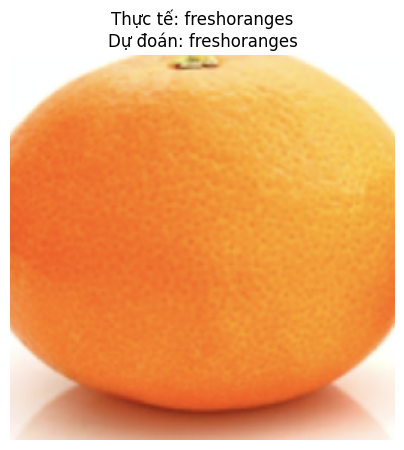

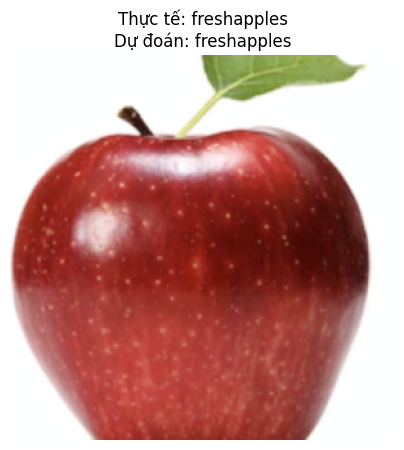

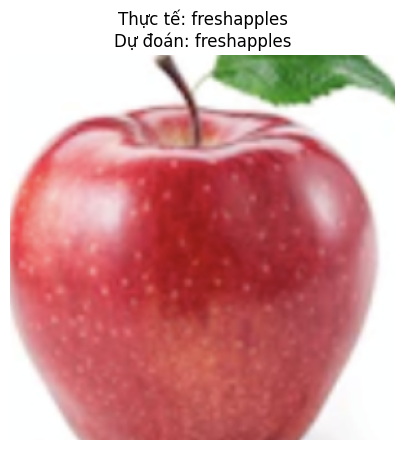

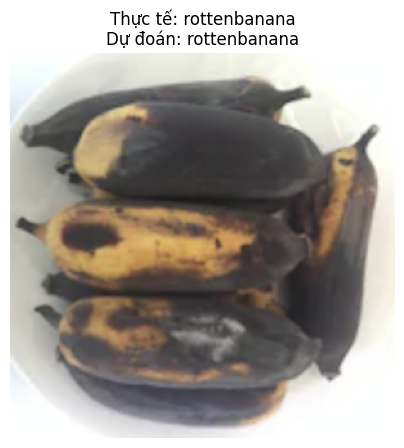

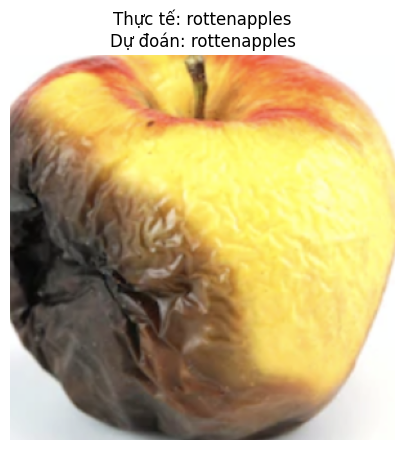

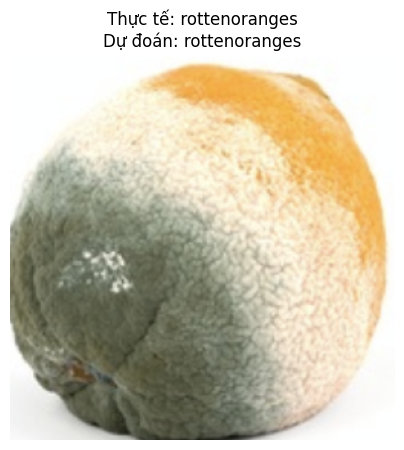

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
from PIL import Image
import random

# Chuyển sang chế độ đánh giá
my_model.eval()
val_running_loss = 0.0
val_correct, val_total = 0, 0

# Danh sách tên lớp
class_names = ["freshapples", "freshbanana", "freshoranges",
               "rottenapples", "rottenbanana", "rottenoranges"]

# Tính toán loss và accuracy trên toàn bộ tập valid
with torch.no_grad():
    for val_inputs, val_labels in valid_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = my_model(val_inputs)
        val_loss = loss_function(val_outputs, val_labels)

        val_running_loss += val_loss.item() * val_inputs.size(0)
        _, val_predicted = torch.max(val_outputs, 1)
        val_total += val_labels.size(0)
        val_correct += (val_predicted == val_labels).sum().item()

val_loss = val_running_loss / len(valid_loader.dataset)
val_acc = val_correct / val_total
print(f'Epoch {epoch+1}/{num_epochs} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_acc:.4f}')

# Phân loại chỉ số theo nhóm "fresh" và "rotten"
fresh_indices = [i for i in range(len(valid_loader.dataset))
                 if valid_loader.dataset[i][1] in [0, 1, 2]]  # Nhãn 0, 1, 2 là "fresh"
rotten_indices = [i for i in range(len(valid_loader.dataset))
                  if valid_loader.dataset[i][1] in [3, 4, 5]]  # Nhãn 3, 4, 5 là "rotten"

# Số ảnh muốn hiển thị từ mỗi nhóm
num_images_per_group = 3  # 2 ảnh từ "fresh" và 2 ảnh từ "rotten"
total_images = num_images_per_group * 2  # Tổng cộng 4 ảnh

# Chọn ngẫu nhiên từ mỗi nhóm
random_fresh_indices = random.sample(fresh_indices, min(num_images_per_group, len(fresh_indices)))
random_rotten_indices = random.sample(rotten_indices, min(num_images_per_group, len(rotten_indices)))
random_indices = random_fresh_indices + random_rotten_indices

# Dự đoán và hiển thị ảnh ngẫu nhiên
my_model.eval()
with torch.no_grad():
    for idx in random_indices:
        # Lấy ảnh và nhãn từ dataset
        image, true_label = valid_loader.dataset[idx]
        image = image.unsqueeze(0).to(device)  # Thêm chiều batch

        # Dự đoán
        output = my_model(image)
        _, pred_label = torch.max(output, 1)
        pred_label = pred_label.item()
        true_label = true_label if isinstance(true_label, int) else true_label.item()

        # Chuyển ảnh về định dạng hiển thị
        img = image.cpu().squeeze(0).permute(1, 2, 0).numpy()  # (C,H,W) -> (H,W,C)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Đảo ngược chuẩn hóa
        img = np.clip(img, 0, 1)

        # Hiển thị ảnh
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"Thực tế: {class_names[true_label]}\nDự đoán: {class_names[pred_label]}")
        plt.axis('off')
        plt.show()

In [ ]:
# my_model.eval()
# correct, total = 0, 0

# with torch.no_grad():
#     for inputs, labels in valid_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = my_model(inputs)
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# valid_acc = correct / total
# print(f'Validation Accuracy: {valid_acc:.4f}')

Validation Accuracy: 0.8997


In [ ]:
label_names = train_loader.dataset